# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [105]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets

import warnings
warnings.filterwarnings('ignore')

In [106]:
# Read the Mapbox API key
load_dotenv('example.csv')
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [107]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()

neighborhood_coordinate_path = Path("Data/neighborhoods_coordinates.csv")
neighbor_cord_df = pd.read_csv(neighborhood_coordinate_path)
neighbor_cord_df.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [143]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    sfo_avg_data = sfo_data[['housing_units']].groupby(by ='year').mean()
    
    minimum = sfo_avg_data['housing_units'].min() - sfo_avg_data['housing_units'].std()
    maximum = sfo_avg_data['housing_units'].max() + sfo_avg_data['housing_units'].std()
    plot = sfo_avg_data.plot(kind = 'bar', title = 'Housing Units - Y axix limits set with , min, max & std').set_ylim([minimum,maximum])
    
    return plot

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    sfo_avg_data = sfo_data[['gross_rent']].groupby(by ='year').mean()
    plot = sfo_avg_data['gross_rent'].plot(title = 'Avg Gross Rent by Year')
    
    return plot

def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_avg_data = sfo_data[['sale_price_sqr_foot']].groupby(by ='year').mean()
    plot = sfo_avg_data['sale_price_sqr_foot'].plot(title = 'Sale PRice per Sq Ft')
    
    return plot


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    neighborhoods = sfo_df.neighborhood.unique()
    
    # Define function to create plot
    def plot_avg_price(neighborhood):
        df = sfo_df.loc[sfo_df['neighborhood'] == neighborhood ]
        
        return df.hvplot.line(
            x = "year",
            y = "sale_price_sqr_foot",
            title="Average price per sq ft", 
            )
    return interact(plot_avg_price, neighborhood = neighborhoods)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_df_top_10 = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False )
    sfo_df_top_10 = sfo_df_top_10.reset_index().head(10)
    
    plot1 = sfo_df_top_10.plot.bar(x = 'neighborhood', y =['sale_price_sqr_foot', 'gross_rent'], title = 'Sale price/ Sq Ft & Gross Rent' )
    plot2 = sfo_df_top_10.plot.bar(x = 'neighborhood', y =['housing_units'], title = 'Housing Units' ).set_ylim([374000,383000])
    
    return plot1, plot2


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods.""" 
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_df_top_10 = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False )
    sfo_df_top_10 = sfo_df_top_10.reset_index().head(10)
    neighborhoods_top_10 = sfo_df_top_10.neighborhood.unique()

    def plot_avg_price(neighborhood):
        df = sfo_df.loc[sfo_df['neighborhood'] == neighborhood ]

        return df.hvplot.line(
            x = "year",
            y = ["sale_price_sqr_foot"],
            title="Sale Price per Sq Ft"
        )

    def plot_gross_rent(neighborhood):
        df = sfo_df.loc[sfo_df['neighborhood'] == neighborhood ]

        return df.hvplot.line(
            x = "year",
            y = ["gross_rent", "sale_price_sqr_foot"],
            title="Average Monthly Rent"
        )

    # Render plot with Panel interactive widget
    return pn.Row(interact(plot_avg_price, neighborhood = neighborhoods_top_10), interact(plot_gross_rent, neighborhood = neighborhoods_top_10))
    
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    """Parallel Categories Plot."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_df_neighborhood = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False )
    sfo_df_neighborhood = sfo_df_neighborhood.reset_index().head(10)
    neighborhoods_top_10 = sfo_df_neighborhood.neighborhood.unique()
    
    df_expensive_neighborhoods_per_year = sfo_df[sfo_df["neighborhood"].isin(neighborhoods_top_10)]
    df_top_10 = df_expensive_neighborhoods_per_year.groupby('neighborhood').mean().reset_index().sort_values("sale_price_sqr_foot", ascending=False)
    
    parallel_plot = px.parallel_coordinates(
        df_top_10,
        dimensions=["neighborhood","sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood": "Neighborhood",
            "sale_price_sqr_foot" : "Sale Price Sq Ft",
            "housing_units": "Housing_units",
            "gross_rent": "Gross_rent"
        },
        width = 800
        )
    return parallel_plot
    

def parallel_categories():
    """Parallel Categories Plot."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_df_neighborhood = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False )
    sfo_df_neighborhood = sfo_df_neighborhood.reset_index().head(10)
    neighborhoods_top_10 = sfo_df_neighborhood.neighborhood.unique()
    
    df_expensive_neighborhoods_per_year = sfo_df[sfo_df["neighborhood"].isin(neighborhoods_top_10)]
    df_top_10 = df_expensive_neighborhoods_per_year.groupby('neighborhood').mean().reset_index().sort_values("sale_price_sqr_foot", ascending=False)

    parallel_plot = px.parallel_categories(
        df_top_10,
        dimensions=["neighborhood","sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood": "Neighborhood",
            "housing_units": "Housing_units",
            "gross_rent": "Gross_rent"
            },
        width = 800
        )
    
    
    return parallel_plot


px.set_mapbox_access_token(map_box_api)

def neighborhood_map():
    """Neighborhood Map."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_neighborhood_mean = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().reset_index()
    sfo_cord_df = neighbor_cord_df.join(sfo_neighborhood_mean.set_index(['neighborhood']), on = 'Neighborhood', how ='inner')
    
    # Create a scatter mapbox to analyze neighborhood info
    map_plot = px.scatter_mapbox(
        sfo_cord_df,
        lat="Lat",
        lon="Lon",
        size = "sale_price_sqr_foot", 
        color="gross_rent",
        zoom = +10
    )

    print(type(map_plot))
    return map_plot


def sunburst():
    """Sunburst Plot."""
    sfo_df = sfo_data.groupby(by=['year', 'neighborhood']).mean().reset_index()
    sfo_df_neighborhood = sfo_df[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].groupby('neighborhood').mean().sort_values(by='sale_price_sqr_foot', ascending=False )
    sfo_df_neighborhood = sfo_df_neighborhood.reset_index().head(10)
    neighborhoods_top_10 = sfo_df_neighborhood.neighborhood.unique()
    
    df_2 = sfo_df[sfo_df["neighborhood"].isin(neighborhoods_top_10)][['year','neighborhood','sale_price_sqr_foot', 'gross_rent']]
    
    sunburstplot = px.sunburst(
        df_2,
        path=["year","neighborhood"],
        values = "sale_price_sqr_foot",
        color="gross_rent"
        )
    return sunburstplot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

# San Francisco Rental Prices Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(tuple)
    [1] Row
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)

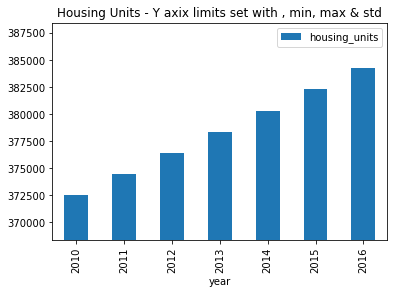

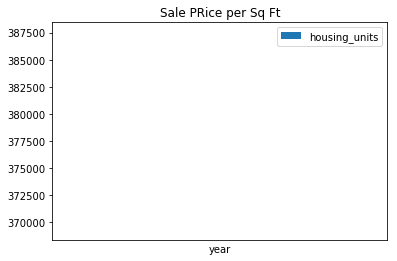

In [144]:
# Create a Title for the Dashboard
plots_as_column = pn.Column(
    "# San Francisco Rental Prices Dashboard", housing_units_per_year())

housing_unit = pn.Column(
    "## Housing Unit per Year", housing_units_per_year()
) 

average_rent_price = pn.Row(
'## Aerage Rent & Sales', average_gross_rent(), average_sales_price())
# Create a tab layout for the dashboard
# YOUR CODE HERE!


# Create the dashboard
tabs = pn.Tabs(
    ("Housing Unit", housing_unit),
    ("Aerage Rent & Price", average_rent_price),
    
    
)

tabs

## Serve the Panel Dashboard

In [ ]:
# Serve the# dashboard
# YOUR CODE HERE!

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [34]:
# housing_units_per_year()

In [35]:
# average_gross_rent()

In [36]:
# average_sales_price()

In [65]:
# average_price_by_neighborhood()

In [72]:
# top_most_expensive_neighborhoods()

In [78]:
# most_expensive_neighborhoods_rent_sales()

In [111]:
neighborhood_map().show()

<class 'plotly.graph_objs._figure.Figure'>


In [124]:
# parallel_categories()

In [129]:
# parallel_coordinates()

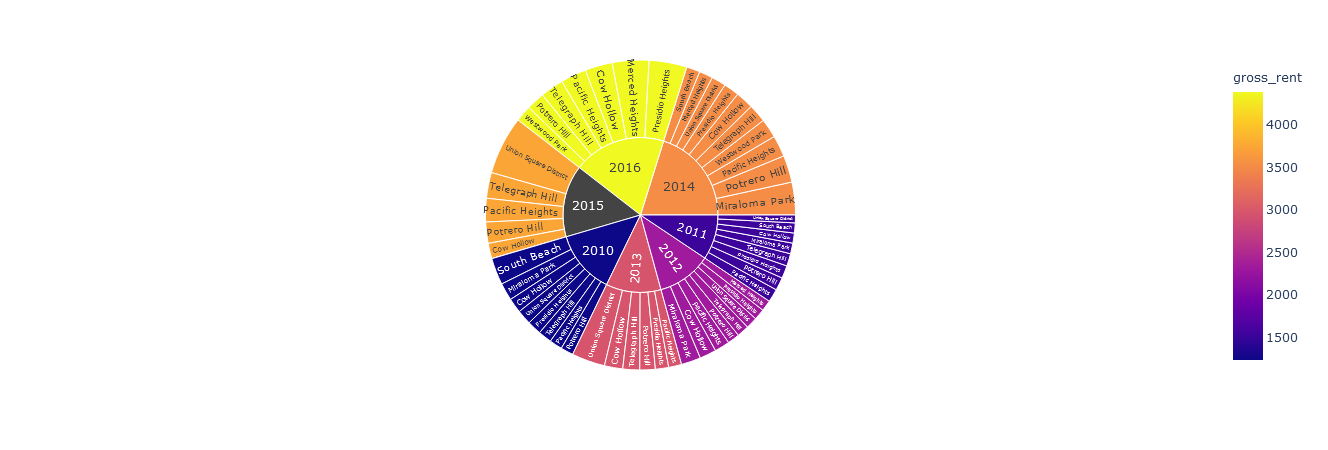

In [132]:
sunburst()